# Coupled Random Walk Metropolis (RWM)

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal, uniform

import matplotlib.pyplot as plt
import importlib

In [15]:
import utils.rejection_coupling_plot as rcp
importlib.reload(rcp)
from utils.rejection_coupling_plot import run_rejection_coupling, plot_rejection_coupling

In [16]:
import utils.tests as test
importlib.reload(test)
from utils.tests import run_coupling_test

In [17]:
def reflection_maximal_coupling(a, b, Sigma):
    """
    Sample a reflection-maximal coupling of two Gaussians:
    X ~ N(a, Sigma), Y ~ N(b, Sigma)
    """
    # Compute z and unit direction e
    C = np.linalg.cholesky(Sigma)
    Sigma_sqrt_inv = np.linalg.inv(C)
    z = Sigma_sqrt_inv @ (a - b)
    norm_z = np.linalg.norm(z)
    e = z / norm_z

    # Sample Ẋ ~ N(0, I), U ~ U(0,1)
    dim = len(a)
    X_dot = np.random.normal(0, 1, size=dim)
    U = np.random.uniform()
    
    standard_normal = multivariate_normal(mean=np.zeros(dim), cov=np.eye(dim))
    if standard_normal.pdf(X_dot) * U < standard_normal.pdf(X_dot + z):
        Y_dot = X_dot + z
    else:
        Y_dot = X_dot - 2 * np.dot(X_dot, e) * e

    X = a + C @ X_dot
    Y = b + C @ Y_dot
    return X, Y

## 1. Random Walk Metropolis (RWM)

The **Random Walk Metropolis (RWM)** algorithm is a fundamental Markov Chain Monte Carlo (MCMC) method for sampling from a target distribution $\pi(x)$. At each iteration, the algorithm proposes a new state by taking a random step from the current state, and then decides whether to accept or reject this proposal based on the target density.

### Algorithm Steps

Given the current state $x_t$, the RWM algorithm proceeds as follows:

1. **Proposal**  
   Sample a new point using a symmetric Gaussian proposal:
   $$
   x' = x_t + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \Sigma)
   $$

2. **Acceptance Probability**  
   Compute the Metropolis acceptance ratio:
   $$
   \alpha = \min\left(1, \frac{\pi(x')}{\pi(x_t)}\right)
   $$

3. **Update**  
   Accept or reject the proposal:
   - With probability $\alpha$ , set $x_{t+1} = x'$
   - Otherwise, set $x_{t+1} = x_t$

### Why It Works

The algorithm is designed to construct a Markov chain that has $\pi$ as its stationary distribution. It satisfies the **detailed balance condition**:
$$
\pi(x) P(x, x') = \pi(x') P(x', x)
$$
This ensures convergence to $\pi$ as the number of iterations increases.

### Application 

In our case, the target distribution is the **standard multivariate normal distribution**:
$$
\pi(x) \propto \exp\left(-\frac{1}{2} \|x\|^2\right)
$$

We initialize two chains from distant initial values and couple them using a **reflection-maximal Gaussian proposal**. This allows us to measure **coupling time**, which gives insight into the convergence properties of the RWM algorithm.


## 2. Coupling Methodology

To evaluate the convergence behavior of the Random Walk Metropolis (RWM) algorithm, we use a **coupled version** of the algorithm. In this approach, we run two RWM chains in parallel, starting from different initial positions, and track the time it takes for them to **meet** — that is, to reach the same state and evolve identically afterward.

### Initial Conditions

We initialize two chains with the following starting points:
- $ x_0 = 5.0 $
- $ y_0 = -5.0 $

### Coupled Proposals

At each iteration, we use a **reflection-maximal coupling** to propose correlated moves from:
- $ \mathcal{N}(x_t, \Sigma) $ for the first chain, and
- $ \mathcal{N}(y_t, \Sigma) $ for the second chain,

where $ \Sigma = \sigma^2 I $ is the shared covariance matrix. This coupling maximizes the probability that the proposals for both chains will be equal.

A single uniform random variable $ u \sim \mathcal{U}(0, 1) $ is used to synchronize the Metropolis acceptance step for both chains.

### Meeting Time

The **meeting time** $ \tau $ is defined as the first time step at which the two chains are numerically indistinguishable:
$$
\|x_t - y_t\| < 10^{-10}
$$

Once the chains meet, they evolve identically due to the shared randomness in both proposal and acceptance decisions.

This coupling approach enables us to empirically study convergence and to build **unbiased MCMC estimators**.


In [18]:
def log_pi(x):
    # Standard multivariate normal
    return -0.5 * np.dot(x, x)

In [21]:
def coupled_rwm(x0, y0, Sigma, n_iter=1000):
    x_chain = [x0]
    y_chain = [y0]
    meeting_time = None
    dim = len(x0)

    x = x0
    y = y0

    for t in range(n_iter):
        # Coupled proposal step
        x_prop, y_prop = reflection_maximal_coupling(x, y, Sigma)

        # Common uniform variable for accept/reject coupling
        u = np.random.uniform()

        # Accept/reject for x
        log_alpha_x = min(0.0, log_pi(x_prop) - log_pi(x))
        if np.log(u) < log_alpha_x:
            x = x_prop

        # Accept/reject for y
        log_alpha_y = min(0.0, log_pi(y_prop) - log_pi(y))
        if np.log(u) < log_alpha_y:
            y = y_prop

        x_chain.append(x)
        y_chain.append(y)

        # Record meeting time
        if meeting_time is None and np.allclose(x, y, atol=1e-10):
            meeting_time = t + 1  # they meet after this step

    return np.array(x_chain), np.array(y_chain), meeting_time


In [24]:
np.random.seed(2025)

dim = 1
sigma = 0.5
Sigma = sigma**2 * np.eye(dim)

x0 = np.array([5.0])      
y0 = np.array([-5.0])     

x_chain, y_chain, tau = coupled_rwm(x0, y0, Sigma, n_iter=500)

print(f"Meeting time: {tau}")


Meeting time: 38


/var/folders/q6/lcytr3pd0v71b1h5m0wkt4b40000gn/T/ipykernel_38245/380702980.py:11: RuntimeWarning: invalid value encountered in divide
  e = z / norm_z


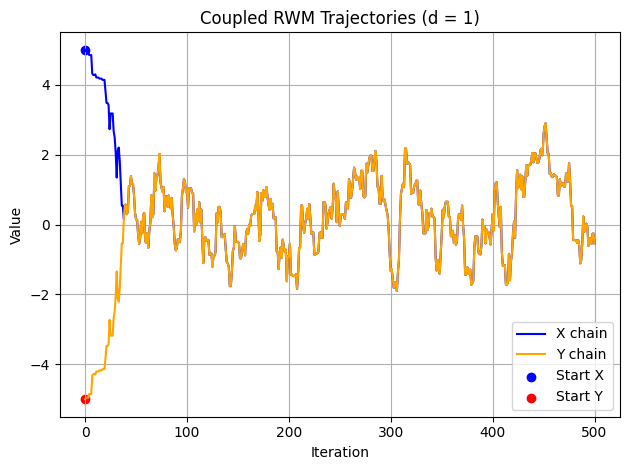

In [25]:
import matplotlib.pyplot as plt
import numpy as np

steps = np.arange(len(x_chain))

plt.plot(steps, x_chain[:, 0], label='X chain', color='blue')
plt.plot(steps, y_chain[:, 0], label='Y chain', color='orange')
plt.scatter(0, x_chain[0, 0], c='blue', label='Start X')
plt.scatter(0, y_chain[0, 0], c='red', label='Start Y')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title("Coupled RWM Trajectories (d = 1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. Experimental Results Across Dimensions

To further explore how dimensionality affects coupling behavior, we run the coupled RWM algorithm for three different values of the dimension: $ d = 1 $, $ d = 5 $, and $ d = 10 $. For each case, we visualize the trajectories of the two chains to observe how and when they meet.

### Setup

- **Proposal standard deviation**: $ \sigma = 0.5 $
- **Covariance matrix**: $ \Sigma = \sigma^2 I_d $
- **Number of iterations**: 300
- **Initial positions**:
  - $ x_0 = (5, \dots, 5) \in \mathbb{R}^d $
  - $ y_0 = (-5, \dots, -5) \in \mathbb{R}^d $

At each step, we use reflection-maximal coupling for the proposal and a shared uniform random variable for the accept/reject step.

### Visualization

We generate trajectory plots for each dimension:

- **For $ d = 1 $**:  
  The trajectories are plotted over time as 1D values. The blue and orange lines represent the paths of the two chains before meeting. Once they meet, the shared path is shown in green.

- **For $ d = 5 $ and $ d = 10 $**:  
  To visualize these higher-dimensional paths, we project the chains onto their first two coordinates (i.e., plot $ (x^{(1)}_t, x^{(2)}_t) $). This allows us to observe the motion and eventual meeting of the chains in a 2D plane.

Each subplot displays the **meeting time** in the title, which is the first step at which $ \|x_t - y_t\| < 10^{-10} $.

### Observations

- In lower dimensions (e.g., $ d = 1 $), the chains tend to meet faster and the behavior is smoother.
- As the dimension increases, the chains explore a higher-dimensional space, which may lead to **longer coupling times** and more erratic trajectories before meeting.
- After the meeting time, both chains remain perfectly synchronized due to the shared randomness.

This experiment highlights how dimensionality impacts the performance and coupling behavior of the Random Walk Metropolis algorithm, providing insight into the challenges of scaling MCMC methods.


/var/folders/q6/lcytr3pd0v71b1h5m0wkt4b40000gn/T/ipykernel_38245/380702980.py:11: RuntimeWarning: invalid value encountered in divide
  e = z / norm_z


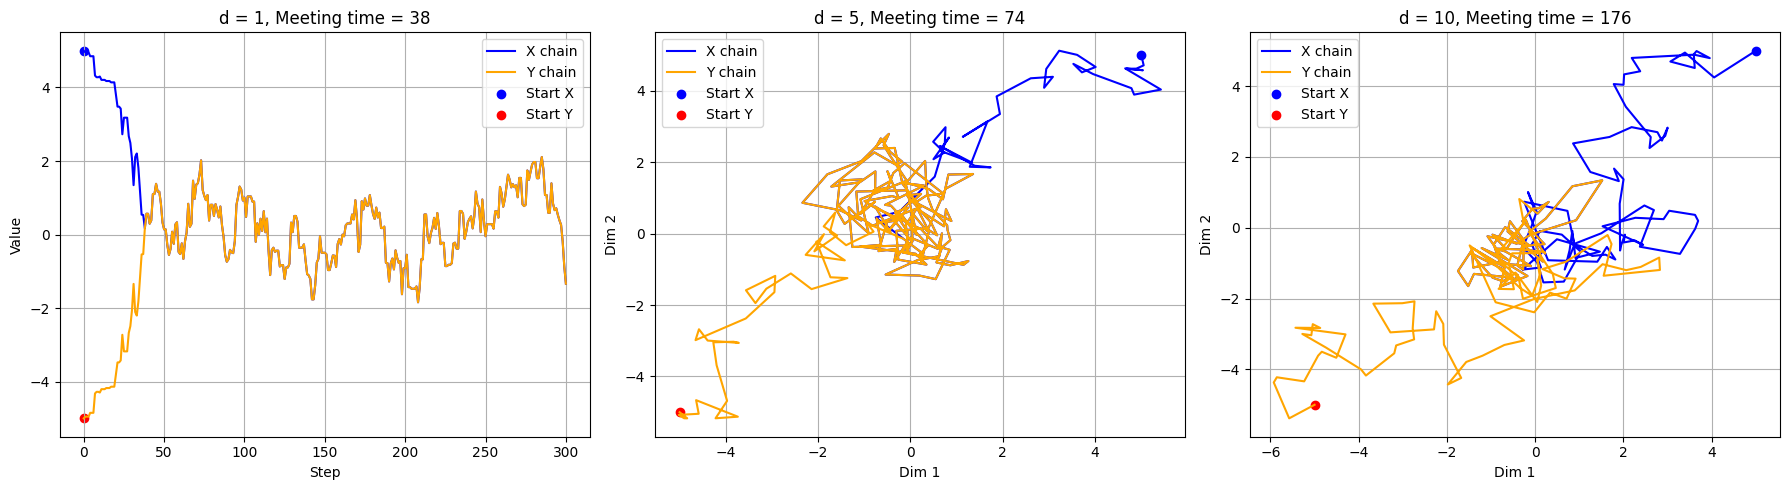

In [28]:
np.random.seed(2025)
# Run and plot for d = 1, 5, 10 
dimensions = [1, 5, 10]
sigma = 0.5
n_iter = 300

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, d in enumerate(dimensions):
    Sigma = sigma**2 * np.eye(d)
    x0 = np.ones(d) * 5
    y0 = -np.ones(d) * 5
    x_chain, y_chain, meeting_time = coupled_rwm(x0, y0, Sigma, n_iter=n_iter)

    ax = axes[idx]

    if d == 1:
        ax.plot(np.arange(len(x_chain)), x_chain[:, 0], label='X chain', color='blue')
        ax.plot(np.arange(len(y_chain)), y_chain[:, 0], label='Y chain', color='orange')
        ax.scatter(0, x_chain[0, 0], c='blue', label='Start X')
        ax.scatter(0, y_chain[0, 0], c='red', label='Start Y')
        ax.set_xlabel('Step')
        ax.set_ylabel('Value')
    else:
        ax.plot(x_chain[:, 0], x_chain[:, 1], label='X chain', color='blue')
        ax.plot(y_chain[:, 0], y_chain[:, 1], label='Y chain', color='orange')
        ax.scatter(x_chain[0, 0], x_chain[0, 1], c='blue', label='Start X')
        ax.scatter(y_chain[0, 0], y_chain[0, 1], c='red', label='Start Y')
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')

    ax.set_title(f"d = {d}, Meeting time = {meeting_time}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


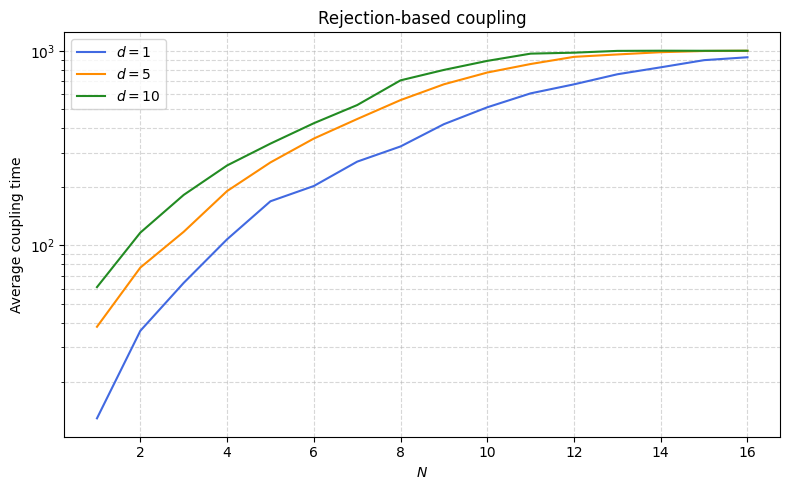

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def coupled_rwm(x0, y0, Sigma, n_iter=1000):
    meeting_time = None
    x = x0
    y = y0

    for t in range(n_iter):
        x_prop, y_prop = reflection_maximal_coupling(x, y, Sigma)
        u = np.random.uniform()

        log_alpha_x = min(0.0, log_pi(x_prop) - log_pi(x))
        if np.log(u) < log_alpha_x:
            x = x_prop

        log_alpha_y = min(0.0, log_pi(y_prop) - log_pi(y))
        if np.log(u) < log_alpha_y:
            y = y_prop

        if meeting_time is None and np.allclose(x, y, atol=1e-10):
            meeting_time = t + 1
            break

    return meeting_time if meeting_time is not None else n_iter

np.random.seed(2025)

# Parameters for the experiment
dimensions = [1, 5, 10]
N_values = np.arange(1, 17)  # Analogous to N in the figure
repeats = 50

# Collect results
results = {d: [] for d in dimensions}

for d in dimensions:
    for N in N_values:
        Sigma = (1.0 / N)**2 * np.eye(d)  # Step size inversely related to N
        times = []
        for _ in range(repeats):
            x0 = np.ones(d) * 5
            y0 = -np.ones(d) * 5
            t_meet = coupled_rwm(x0, y0, Sigma, n_iter=1000)
            times.append(t_meet)
        avg_time = np.mean(times)
        results[d].append(avg_time)

# Plotting
plt.figure(figsize=(8, 5))
for d, color in zip(dimensions, ['royalblue', 'darkorange', 'forestgreen']):
    plt.plot(N_values, results[d], label=f'$d={d}$', color=color)

plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('Average coupling time')
plt.title('Rejection-based coupling')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
